In [1]:
import os
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import plotly.express as px
from uatk_spc.reader import SPCReaderParquet as SPCReader

#### Load example region


In [2]:
# path = "../../data/output/Scotland/2020"
# region = "fife"
# path = "../../data/output/England/2020"
# region = "rutland"
path = "../../data/output/special/2020"
region = "northwest_transpennine"

In [3]:
# Read from parquet and JSON
spc = SPCReader(path, region, backend="polars")


In [4]:
# Show households after read from parquet and JSON
spc.households

id,msoa,oa,members,details
u64,str,str,list[u64],struct[8]
0,"""E02000984""","""E00024181""",[0],"{""E02000984_0001"",5,4,null,6,true,1,2}"
1,"""E02000984""","""E00024324""","[1, 2, 3]","{""E02000984_0002"",5,2,null,5,true,5,0}"
2,"""E02000984""","""E00024360""",[4],"{""E02000984_0003"",3,3,null,4,true,2,2}"
3,"""E02000984""","""E00024349""","[5, 6]","{""E02000984_0004"",6,3,null,6,true,1,2}"
4,"""E02000984""","""E00024182""","[7, 8]","{""E02000984_0005"",1,1,null,6,true,1,2}"
5,"""E02000984""","""E00024347""","[9, 10]","{""E02000984_0006"",2,1,null,6,true,1,2}"
6,"""E02000984""","""E00024349""","[11, 12]","{""E02000984_0007"",1,1,null,6,true,2,2}"
7,"""E02000984""","""E00024322""","[13, 14]","{""E02000984_0008"",2,1,null,6,true,1,2}"
8,"""E02000984""","""E00024181""","[15, 16]","{""E02000984_0009"",2,2,null,6,true,1,2}"


#### Plot venues


In [14]:
for filter_work in [False]:
    # Plot all non-work venues
    if filter_work:
        df = spc.venues_per_activity.unnest("location")
    else:
        df = spc.venues_per_activity.unnest("location").filter(pl.col("activity")!="Work")
    print(df)
    px.set_mapbox_access_token(os.getenv("MAPBOX_KEY"))
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
    fig.show()


shape: (1_090, 5)
┌─────┬─────────────────┬───────────┬───────────┬────────┐
│ id  ┆ activity        ┆ longitude ┆ latitude  ┆ urn    │
│ --- ┆ ---             ┆ ---       ┆ ---       ┆ ---    │
│ u64 ┆ str             ┆ f32       ┆ f32       ┆ str    │
╞═════╪═════════════════╪═══════════╪═══════════╪════════╡
│ 0   ┆ Retail          ┆ -2.074379 ┆ 53.452232 ┆ null   │
│ 1   ┆ Retail          ┆ -2.328571 ┆ 53.557266 ┆ null   │
│ 2   ┆ Retail          ┆ -2.372781 ┆ 53.756626 ┆ null   │
│ 3   ┆ Retail          ┆ -2.135604 ┆ 53.612152 ┆ null   │
│ …   ┆ …               ┆ …         ┆ …         ┆ …      │
│ 315 ┆ SecondarySchool ┆ -2.409898 ┆ 53.523178 ┆ 133351 │
│ 316 ┆ SecondarySchool ┆ -2.882303 ┆ 53.485481 ┆ 135479 │
│ 317 ┆ SecondarySchool ┆ -2.122063 ┆ 53.461025 ┆ 135122 │
│ 318 ┆ SecondarySchool ┆ -2.786528 ┆ 53.418518 ┆ 135481 │
└─────┴─────────────────┴───────────┴───────────┴────────┘


### 2. Explore demographic and health data

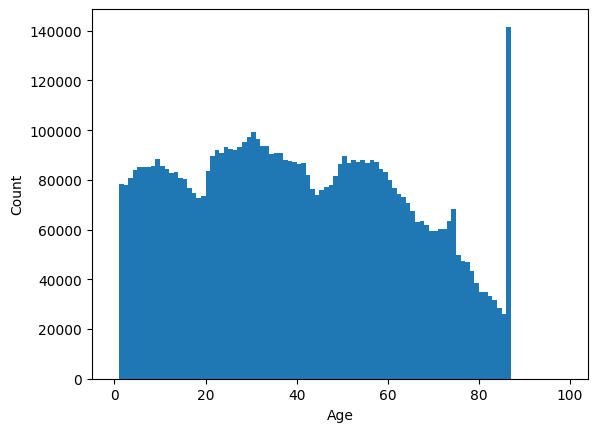

In [6]:
# Plot Age
plt.hist(
    spc.people.unnest("demographics").select("age_years"), bins=np.arange(0, 100, 1)
)
plt.gca().set(xlabel="Age", ylabel="Count")
plt.show()

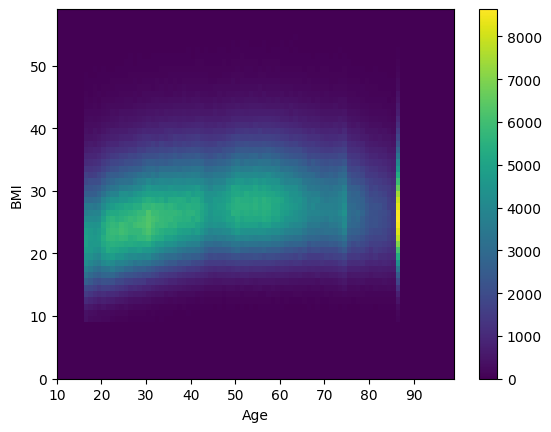

In [7]:
# Plot 2D hist of Age and BMI
age_bmi = (
    spc.people.unnest("demographics")
    .unnest("health")
    .select(["age_years", "bmi"])
    .filter(pl.col("bmi") != None)
    .to_numpy()
)
plt.hist2d(age_bmi[:, 0], age_bmi[:, 1], bins=[np.arange(10, 100), np.arange(0, 60)])
plt.gca().set(xlabel="Age", ylabel="BMI")
plt.colorbar()
plt.show()

#### 2.2 Combine with weekday diaries

__Question: Are weekday activities related to health features?__

Pick some features to explore, merge and aggregate

In [8]:
# Merge and aggregate
features = {"health": ["bmi"], "demographics": ["age_years"]}
merged = spc.merge_people_and_time_use_diaries(features, "weekday_diaries")
# List of activities
activities = merged.select(
    cs.starts_with("pm") | cs.matches("pleisure")
).columns
# Mean per person
merged_agg = (
    merged.select(["id"] + activities + features["health"] + features["demographics"])
    .groupby(["id"], maintain_order=True)
    .mean()
)

##### Activity and Age

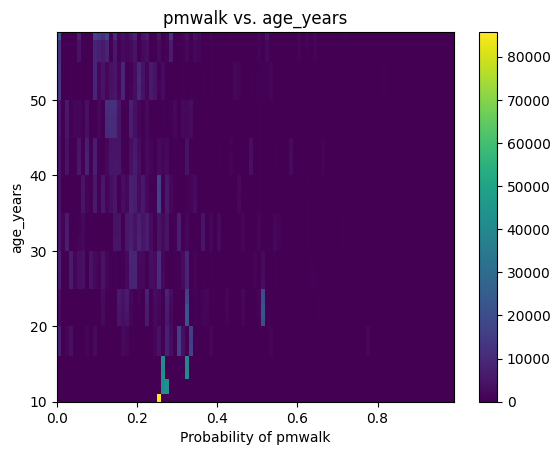

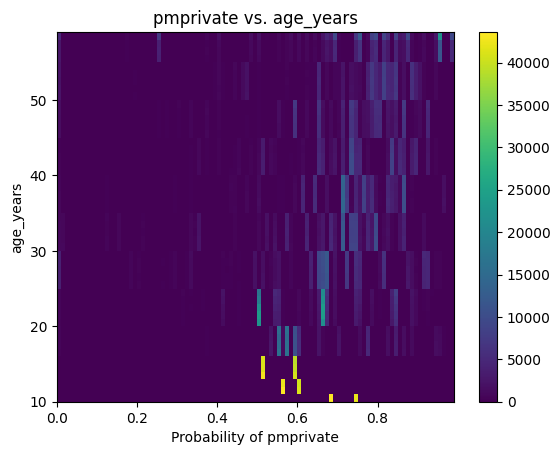

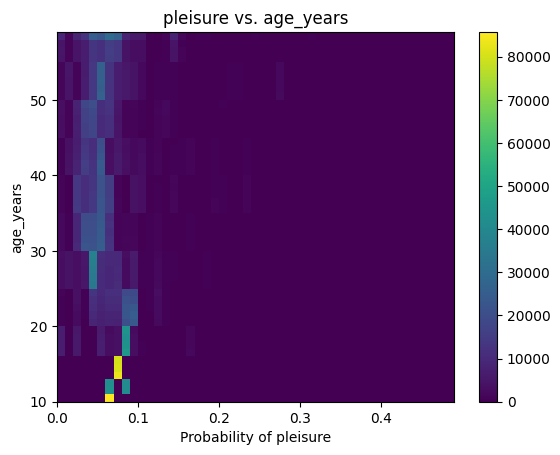

In [9]:
feature = features["demographics"][0]
q = 0.00
for activity in ["pmwalk", "pmprivate", "pleisure"]:
    data = merged_agg.select([activity, feature]).filter(pl.col(feature) != None).to_numpy()
    plt.hist2d(data[:, 0], data[:, 1], bins=[np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1-q), 0.01), np.arange(10, 60)])
    plt.colorbar()
    plt.gca().set(title=f"{activity} vs. {feature}", xlabel=f"Probability of {activity}", ylabel=f"{feature}")
    plt.show()


#### Activity and BMI

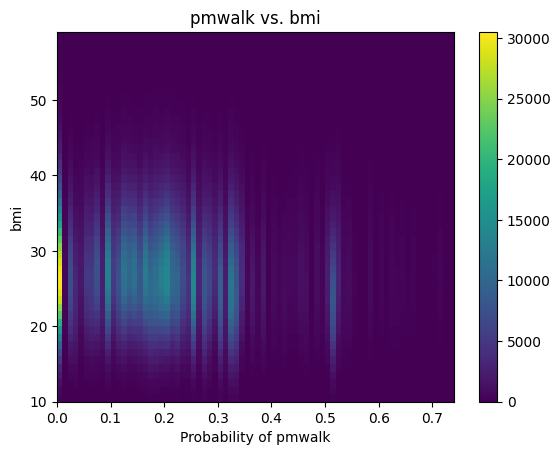

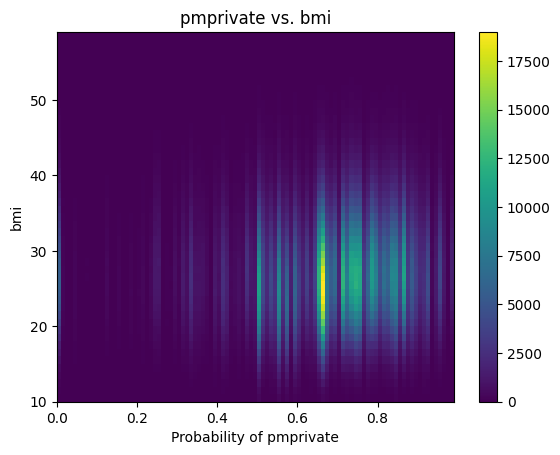

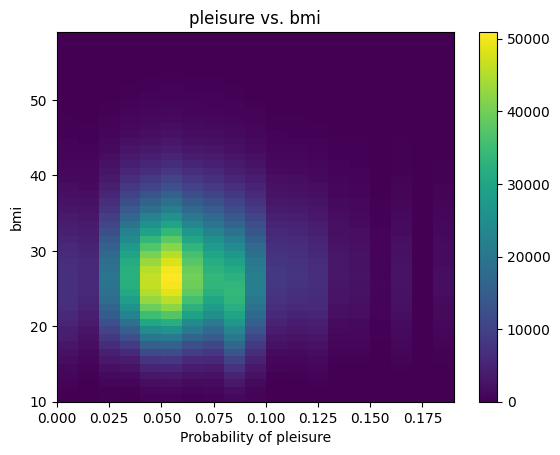

In [10]:

feature = features["health"][0]
q = 0.01
for activity in ["pmwalk", "pmprivate", "pleisure"]:
    data = merged_agg.select([activity, feature]).filter(pl.col(feature) != None).to_numpy()
    plt.hist2d(data[:, 0], data[:, 1], bins=[np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1-q), 0.01), np.arange(10, 60)])
    plt.colorbar()
    plt.gca().set(title=f"{activity} vs. {feature}", xlabel=f"Probability of {activity}", ylabel=f"{feature}")
    plt.show()

In [11]:
# TODO: include additional analysis

### 3. Comparison of regions
Multiple readers can be created to allow comparison and merging of regions.

In [12]:
# TODO

### 4. Explore flows

Flows between MSOAs can be explored using the graph of connections between MSOAs.

In [13]:
# TODO
# spc.info_per_msoa["E02000984"]["flows_per_activity"]